In [1]:
import numpy

import rospy
import tf
from std_msgs.msg import Bool
from sensor_msgs.msg import NavSatFix
from sensor_msgs.msg import Image
from carla_msgs.msg import CarlaCollisionEvent
from carla_msgs.msg import CarlaLaneInvasionEvent
from carla_msgs.msg import CarlaEgoVehicleControl
from carla_msgs.msg import CarlaEgoVehicleStatus
from carla_msgs.msg import CarlaEgoVehicleInfo
from carla_msgs.msg import CarlaStatus

import cv2

import time
import PIL.Image
from io import BytesIO
import IPython.display

In [2]:
import roslaunch

uuid = roslaunch.rlutil.get_or_generate_uuid(None, False)
cli_args = ['/opt/carla-ros-bridge/src/carla_spawn_objects/launch/carla_spawn_objects.launch','objects_definition_file:=/workspace/objects.json']
roslaunch_args = cli_args[1:]
roslaunch_file = [(roslaunch.rlutil.resolve_launch_arguments(cli_args)[0], roslaunch_args)]

parent = roslaunch.parent.ROSLaunchParent(uuid, roslaunch_file)

parent.start()

started roslaunch server http://172.17.0.3:37403/

SUMMARY

PARAMETERS
 * /carla_spawn_objects_8dc3540951a9_1407_6052729855074503334/objects_definition_file: /workspace/object...
 * /carla_spawn_objects_8dc3540951a9_1407_6052729855074503334/spawn_point_ego_vehicle: 
 * /carla_spawn_objects_8dc3540951a9_1407_6052729855074503334/spawn_sensors_only: False
 * /rosdistro: noetic
 * /rosversion: 1.15.9

NODES
  /
    carla_spawn_objects_8dc3540951a9_1407_6052729855074503334 (carla_spawn_objects/carla_spawn_objects.py)

ROS_MASTER_URI=http://172.17.0.2:11311
process[carla_spawn_objects_8dc3540951a9_1407_6052729855074503334-1]: started with pid [1421]


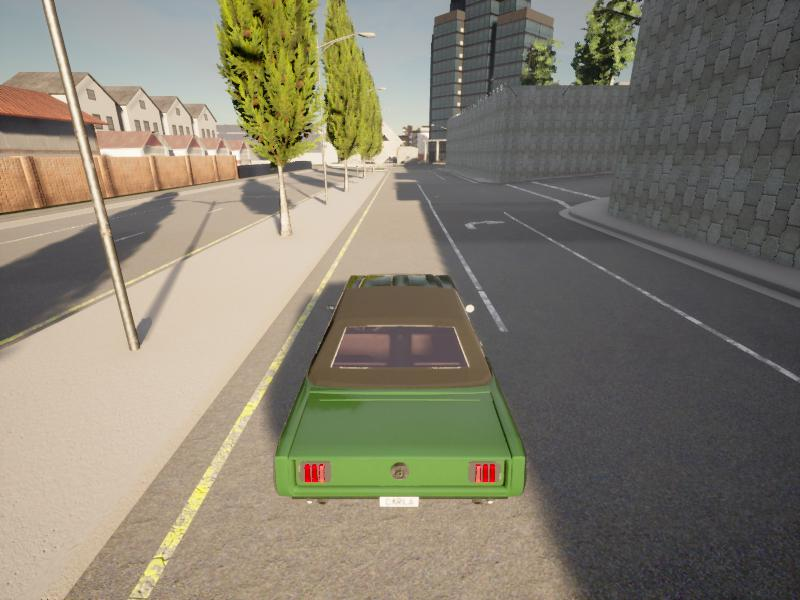

In [11]:
class Xview(object):
    
    display_ids = {}
        
    @staticmethod     
    def showarray(a, prev_display_id=None, fmt='jpeg'):
        f = BytesIO()
        PIL.Image.fromarray(a).save(f, fmt)
        obj = IPython.display.Image(data=f.getvalue())
        if prev_display_id is not None:
            IPython.display.update_display(obj, display_id=prev_display_id)
            return prev_display_id
        else:
            return IPython.display.display(obj, display_id=True)
    
    @staticmethod
    def zoom(frame, scale_percent = 100):
        width = int(frame.shape[1] * scale_percent / 100)
        height = int(frame.shape[0] * scale_percent / 100)
        dsize = (width, height)
        output = cv2.resize(frame, dsize)
        return output
    
    @staticmethod
    def stick_together(a, b, axis=1):
        if axis == 1:
            h = min(a.shape[0], b.shape[0])
            r1 = h / a.shape[0]
            r2 = h / b.shape[0]
            a = cv2.resize(a, (int(r1 * a.shape[1]), int(r1 * a.shape[0])))
            b = cv2.resize(b, (int(r2 * b.shape[1]), int(r2 * b.shape[0])))
            return np.concatenate([a, b], 1)
        else:
            h = min(a.shape[1], b.shape[1])
            r1 = h / a.shape[1]
            r2 = h / b.shape[1]
            a = cv2.resize(a, (int(r1 * a.shape[1]), int(r1 * a.shape[0])))
            b = cv2.resize(b, (int(r2 * b.shape[1]), int(r2 * b.shape[0])))
            return np.concatenate([a, b], 0)
    
    @staticmethod
    def show_image2(name, frame_a, frame_b, scale=100):
        Xview.show_image(name, Xview.stick_together(frame_a, frame_b), scale)
        
    @staticmethod
    def put_text(text, i, j, canvas, fontsize=0.4):
        rows = [x * (canvas.shape[0] // 10) for x in range(10+1)]
        cols = [x * (canvas.shape[1] // 9) for x in range(9+1)]
        cv2.putText(
                canvas, text, (cols[j], rows[i]),
                cv2.FONT_HERSHEY_SIMPLEX, fontsize, (255, 255, 255), 1)
        
    @staticmethod
    def show_image(name, frame, scale=100):
        t1 = time.time()    
        frame = Xview.zoom(frame, scale)
        display_id = Xview.display_ids.get(name)
        if display_id is not None:
            Xview.showarray(frame, display_id)
        else:
            display_handle = Xview.showarray(frame)
            display_id = display_handle.display_id
            Xview.display_ids[name] = display_id
        t2 = time.time()
        return 1/(t2-t1)

In [4]:
def on_view_image(image):
    array = numpy.frombuffer(image.data, dtype=numpy.dtype("uint8"))
    array = numpy.reshape(array, (image.height, image.width, 4))
    array = array[:, :, :3]
    array = array[:, :, ::-1]
    Xview.show_image("windows1",array)

In [5]:
try:
    rospy.init_node('carla_manual_control', anonymous=True)
    #role_name = rospy.get_param("~role_name", "ego_vehicle")
    role_name = 'ego_vehicle_mex'
    print('Controlando el auto {}'.format(role_name))
    
    auto_pilot_enable_publisher = rospy.Publisher(
            "/carla/{}/enable_autopilot".format(role_name), Bool, queue_size=1)
    auto_pilot_enable_publisher.publish(Bool(data=True))
    image_subscriber = rospy.Subscriber(
            "/carla/{}/rgb_view/image".format(role_name),
            Image, on_view_image)
except KeyboardInterrupt:
    logging.info('\nCancelled by user. Bye!')
    parent.shutdown()

Controlando el auto ego_vehicle_mex


In [10]:
auto_pilot_enable_publisher.publish(Bool(data=True))